In [181]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

import importlib
import my_models.matrix_factorization

importlib.reload(my_models.matrix_factorization)
from my_models.matrix_factorization import BasicMF, BiasMF


# split raw data

In [18]:
data = pd.read_csv("../../data/ml-1m/ratings.dat", sep="::", names=["uid", "iid", "rating", "timestamp"])

/var/folders/_7/4gnw6wrj6q74k30mpk7kz5680000gn/T/ipykernel_89321/624236433.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("../../data/ml-1m/ratings.dat", sep="::", names=["uid","iid","rating","timestamp"])


In [68]:
train, test = train_test_split(data, stratify=data.rating.values)

In [69]:
train = train[(train.uid.isin(test.uid)) & (train.iid.isin(test.iid))].copy()
test = test[(test.uid.isin(train.uid)) & (test.iid.isin(train.iid))].copy()

In [71]:
ord_enc = OrdinalEncoder()
train.iloc[:, :2] = ord_enc.fit_transform(train.iloc[:, :2]).astype(int)

In [73]:
test.iloc[:, :2] = ord_enc.transform(test.iloc[:, :2]).astype(int)

In [74]:
train.to_csv("../../data/ml-1m/train.csv", index=False)
test.to_csv("../../data/ml-1m/test.csv", index=False)

# Dataset

In [146]:
class MovieLensDataset(torch.utils.data.Dataset):
    def __init__(self, path: str):
        df = self._load_data(path)
        self.user_ids = self._arange_movie_ids(df.iloc[:, 0])
        self.movie_ids = self._arange_movie_ids(df.iloc[:, 1])
        self.ratings = torch.FloatTensor(df.iloc[:, 2].values)

        self.mean_rating = self.ratings.mean()

    def _load_data(self, path: str):
        return pd.read_csv(path)

    def _arange_movie_ids(self, ids):
        map_id = dict(zip(ids.unique(), np.arange(len(ids.unique()))))
        return torch.LongTensor(list(map(lambda x: map_id[x], ids)))

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        values = []
        for arr in [self.user_ids, self.movie_ids, self.ratings]:
            values.append(arr[idx])

        keys = ["user_id", "movie_id", "rating"]
        return dict(zip(keys, values))

In [147]:
DATA_PATH = "../../data/ml-1m"

In [148]:
datasets = {name: MovieLensDataset(f"{DATA_PATH}/{name}.csv")
            for name in ["train", "test"]}
dataloaders = {name: torch.utils.data.DataLoader(datasets[name], batch_size=128, shuffle=True)
               for name in ["train", "test"]}

# training

In [186]:
EPOCHS = 2

def train_MF_model(mf_model: nn.Module,
                   dataloaders: torch.utils.data.DataLoader
                   ) -> tuple[nn.Module, dict[str, list]]:
    print("Training", model.__name__)

    loss_fn = nn.MSELoss()
    optim = torch.optim.Adam(mf_model.parameters())
    history = {"train": [], "test": []}

    for epoch in range(EPOCHS):
        for phase in ["train", "test"]:
            for batch in dataloaders[phase]:

                preds = mf_model(batch["user_id"], batch["movie_id"])
                loss = loss_fn(batch["rating"], preds)
                if phase == "train":
                    optim.zero_grad()  # reset gradient
                    loss.backward()
                    optim.step()
                history[phase].append(loss.item())

    print("Results for:", model.__name__)
    plt.plot(history["train"])
    plt.title("train")
    plt.show()
    plt.plot(history["test"])
    plt.title("test")
    plt.show()
    print("Difference between test and train on MSE:", np.mean(history["test"]) - np.mean(history["train"]))

    return mf_model, history

Training BasicMF
Results for: BasicMF


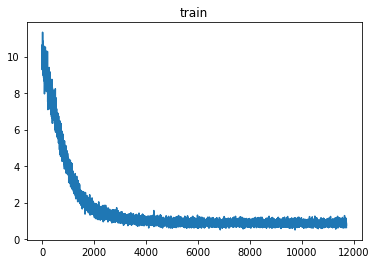

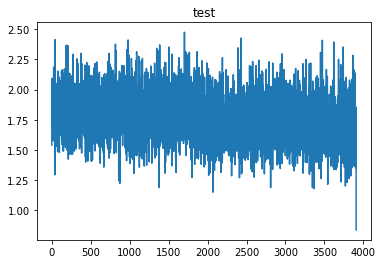

Difference between test and train on MSE: 0.1851648673299029
Training BiasMF
Results for: BiasMF


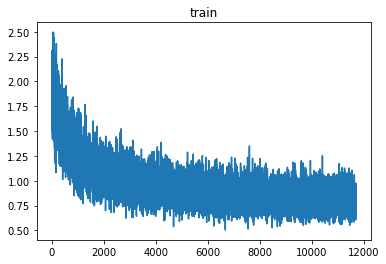

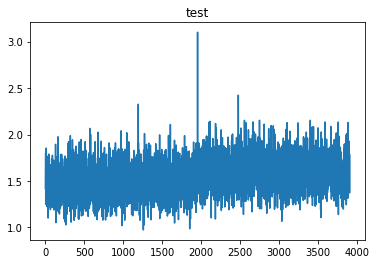

Difference between test and train on MSE: 0.5823292014289813


In [187]:
models = {}

for model in [BasicMF, BiasMF]:
    params={}

    if model.__name__ == "BiasMF":
        params["data_mean"] = datasets["train"].mean_rating


    mf_model = model(n_users=len(datasets["train"].user_ids.unique()),
                     n_items=len(datasets["train"].movie_ids.unique()),
                     embd_dim=10,
                     **params)

    models[model.__name__] = train_MF_model(mf_model, dataloaders)

In [208]:
test_example = next(iter(dataloaders["test"]))
for model_name, (model, _) in models.items():
    preds = model(test_example["user_id"], test_example["movie_id"])
    print(model_name)
    display(pd.DataFrame([test_example["rating"].detach().numpy(),preds.detach().numpy()],index=["true","pred"]).T)

BasicMF


,true,pred
0,4.0,3.773190
1,3.0,4.100941
2,2.0,3.510480
3,2.0,3.636799
4,4.0,3.405061
...,...,...
123,3.0,4.250406
124,3.0,3.748552
125,4.0,1.578959
126,5.0,3.080991


BiasMF


,true,pred
0,4.0,3.746617
1,3.0,4.355735
2,2.0,3.695610
3,2.0,3.587511
4,4.0,3.408024
...,...,...
123,3.0,4.123154
124,3.0,3.919226
125,4.0,2.477681
126,5.0,2.794703


In [244]:
user, movie, rating = [],[],[]
for model_name, (model, _) in models.items():
    for batch in dataloaders["test"]:
        preds = model(batch["user_id"], batch["movie_id"])
        user.extend(batch["user_id"].detach().numpy())
        movie.extend(batch["movie_id"].detach().numpy())
        rating.extend(preds.detach().numpy())
        break

In [246]:
test = pd.DataFrame([user, movie, rating]).T

In [247]:
def get_top_5():

test.sort_values

,0,1,2
0,3113.0,286.0,2.583003
1,1382.0,153.0,2.710730
2,1673.0,477.0,3.160250
3,505.0,328.0,4.841953
4,943.0,1125.0,3.718376
...,...,...,...
251,1460.0,454.0,3.078638
252,2170.0,1526.0,3.778342
253,5168.0,673.0,4.500131
254,1487.0,1836.0,3.683855
